#Amazon Reviews Dataset
An Analysis by Andrew Bauman and Allison Nowakowski

Fall 2019

In [0]:
#Importing the Amazon Reviews Dataset for Pet Products in the US Marketplace
from urllib.request import urlretrieve
import os

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Pet_Products_v1_00.tsv.gz','amazon_reviews_us_Pet_Products_v1_00.tsv.gz')
print("All the files are downloaded")

#Verifying that the file was downloaded
!ls 

Download file... amazon_reviews_us_Pet_Products_v1_00.tsv.gz ...
File downloaded
All the files are downloaded
amazon_reviews_us_Pet_Products_v1_00.tsv.gz  sample_data


In [0]:
#Creating a pandas dataframe with the data, skipping bad lines for now.
import pandas as pd

df = pd.read_csv('amazon_reviews_us_Pet_Products_v1_00.tsv.gz', compression='gzip', sep='\t', header=0, error_bad_lines=False)
df.head()

b'Skipping line 21404: expected 15 fields, saw 22\nSkipping line 31839: expected 15 fields, saw 22\nSkipping line 37779: expected 15 fields, saw 22\nSkipping line 38344: expected 15 fields, saw 22\nSkipping line 61449: expected 15 fields, saw 22\n'
b'Skipping line 80975: expected 15 fields, saw 22\nSkipping line 85603: expected 15 fields, saw 22\nSkipping line 95950: expected 15 fields, saw 22\nSkipping line 105132: expected 15 fields, saw 22\nSkipping line 115378: expected 15 fields, saw 22\n'
b'Skipping line 152632: expected 15 fields, saw 22\nSkipping line 159310: expected 15 fields, saw 22\nSkipping line 162724: expected 15 fields, saw 22\nSkipping line 168588: expected 15 fields, saw 22\nSkipping line 170412: expected 15 fields, saw 22\nSkipping line 187169: expected 15 fields, saw 22\n'
b'Skipping line 205461: expected 15 fields, saw 22\nSkipping line 210928: expected 15 fields, saw 22\nSkipping line 213691: expected 15 fields, saw 22\nSkipping line 228697: expected 15 fields, sa

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,28794885,REAKC26P07MDN,B00Q0K9604,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,5.0,0.0,0.0,N,Y,"A great purchase for ""dribbly"" dogs",Best belly bands on the market! These are a g...,2015-08-31
1,US,11488901,R3NU7OMZ4HQIEG,B00MBW5O9W,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,2.0,0.0,1.0,N,Y,My dogs love Hugs and Kisses,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,43214993,R14QJW3XF8QO1P,B0084OHUIO,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,5.0,0.0,0.0,N,Y,I have been purchasing these for a long time. ...,I have been purchasing these for a long time. ...,2015-08-31
3,US,12835065,R2HB7AX0394ZGY,B001GS71K2,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,5.0,0.0,0.0,N,Y,it is easy to open and close,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,26334022,RGKMPDQGSAHR3,B004ABH1LG,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,5.0,0.0,0.0,N,Y,Dog crate,Worked really well. Very pleased with my purc...,2015-08-31


In [0]:
#Previewing the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639853 entries, 0 to 2639852
Data columns (total 15 columns):
marketplace          object
customer_id          int64
review_id            object
product_id           object
product_parent       int64
product_title        object
product_category     object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtypes: float64(3), int64(2), object(10)
memory usage: 302.1+ MB


In [0]:
#Cleaning/Simplifying the dataset
#Removing unnecessary columns and only keeping reviews from verified purchases.
df=df[['review_id', 'star_rating', 'verified_purchase', 'helpful_votes', 'total_votes', 'review_headline', 'review_body']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639853 entries, 0 to 2639852
Data columns (total 7 columns):
review_id            object
star_rating          float64
verified_purchase    object
helpful_votes        float64
total_votes          float64
review_headline      object
review_body          object
dtypes: float64(3), object(4)
memory usage: 141.0+ MB


In [0]:
#Viewing the data
import seaborn as sns
df.groupby('star_rating').count()

,review_id,verified_purchase,helpful_votes,total_votes,review_headline,review_body
star_rating,,,,,,
1.0,248519,248519,248519,248519,248517,248497
2.0,151067,151067,151067,151067,151065,151067
3.0,216335,216335,216335,216335,216335,216327
4.0,380780,380780,380780,380780,380779,380751
5.0,1643151,1643151,1643151,1643151,1643147,1642994


In [0]:
#Dropping rows without reviews
df_filtered = df.dropna()
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.groupby('star_rating').count()

df_filtered.star_rating.value_counts()

5.0    1642990
4.0     380750
1.0     248495
3.0     216327
2.0     151065
Name: star_rating, dtype: int64

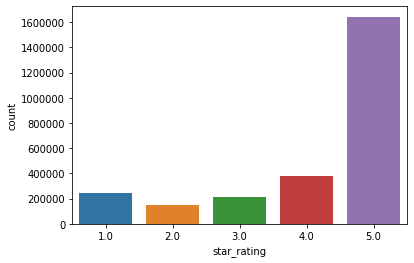

In [0]:
#Viewing the data
sns.countplot(df_filtered.star_rating)

In [0]:
df_minority = df_filtered[df_filtered.star_rating==2.0]
df_minority_count = df_minority.size
df_minority_count

1057455

In [0]:
from sklearn.utils import resample
#Balancing the data
df_majority = df_filtered[df_filtered.star_rating==5.0]
df_minority = df_filtered[df_filtered.star_rating==2.0]
df_oneStar = df_filtered[df_filtered.star_rating==1.0]
df_threeStars = df_filtered[df_filtered.star_rating==3.0]
df_fourStars = df_filtered[df_filtered.star_rating==4.0]
df_minority_count = df_minority.count

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                  replace=False,    # sample without replacement
                                  n_samples=151065, # to match minority class
                                  random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority, df_oneStar, df_threeStars, df_fourStars])

# Display new class counts
df_downsampled.star_rating.value_counts()

4.0    380750
1.0    248495
3.0    216327
5.0    151065
2.0    151065
Name: star_rating, dtype: int64

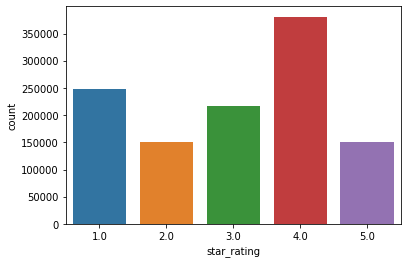

In [0]:
#Viewing the downsampled data
sns.countplot(df_downsampled.star_rating)

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

testData, trainData = train_test_split(df_downsampled, test_size=0.33, random_state=42)


In [0]:
trainData.size

2651194

In [0]:
testData.size

5382720

In [0]:
#Defining a pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()), #adding stop_words='english' lowers accuracy
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=42, solver='sag', multi_class='ovr')),
])
text_clf.fit(trainData.review_body, trainData.star_rating)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [0]:
#Testing the classifer
test_docs = testData.review_body
predictions = text_clf.predict(test_docs)
#Evaluating predictive accuracy of the classifier
np.mean(predictions == testData.star_rating)

0.5467306491885143

In [0]:
#Printing the model metrics
from sklearn import metrics
print(metrics.classification_report(testData.star_rating, predictions))

              precision    recall  f1-score   support

         1.0       0.60      0.79      0.68    166328
         2.0       0.35      0.10      0.15    101078
         3.0       0.42      0.30      0.35    144821
         4.0       0.55      0.77      0.64    255292
         5.0       0.60      0.41      0.49    101441

    accuracy                           0.55    768960
   macro avg       0.51      0.47      0.46    768960
weighted avg       0.52      0.55      0.51    768960



Comparing our model's results to state-of-the-art methods:

https://paperswithcode.com/sota/sentiment-analysis-on-amazon-review-full

# NOTE

The code below is unable to be run on google colab (not enough RAM) and, therefore, we have been unable to run the model and test its accuracy. It is our attempt to create a version of the above model using keras and neural networks. 

In [0]:
#Neural Network Model -- CANNOT RUN ON GOOGLE COLAB;
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer

In [0]:
num_labels = 5
vocab_size = 15000
batch_size = 100
 
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(trainData.review_body)
 
x_train = tokenizer.texts_to_matrix(trainData.review_body, mode='tfidf')
x_test = tokenizer.texts_to_matrix(testData.review_body, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(trainData.review_body)
y_train = encoder.transform(trainData.review_body)
y_test = encoder.transform(testData.review_body)

In [0]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=1,
        verbose=1,
    ),
]

model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(x_train, y_train))

In [0]:
#Evaluating the model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test accuracy:', score[1])
 
text_labels = encoder.classes_
 
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    print(test_data.filename.iloc[i])
    print('Actual label:' + test_data.category.iloc[i])
    print("Predicted label: " + predicted_label)

In [0]:
#Evaluating the model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test accuracy:', score[1])
 
text_labels = encoder.classes_
 
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    print(test_data.filename.iloc[i])
    print('Actual label:' + test_data.category.iloc[i])
    print("Predicted label: " + predicted_label)

In [0]:
#Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(x_test);
cnf_matrix = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-smote" + ".png", pad_inches=5.0)